In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from src.data_loader import load_features
from src.trainers import train_on_split

import pandas as pd
import numpy as np
from src.model_utils import load_model_bundle
from src.data_loader import load_split, load_features, load_target
from src.config import MODELS_DIR, TARGETS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from pathlib import Path
import sys
import joblib
from sklearn.metrics import classification_report
from src.config import DEFAULT_FEATURES


ImportError: cannot import name 'DEFAULT_MODEL_CONFIGS' from 'src.config' (c:\Users\mew\Projects\autotickets-rag-bot\src\config.py)

In [24]:
bundle = load_model_bundle(Path(MODELS_DIR)/'subcategory/run_2025-08-15_12-53-32')

In [25]:
features = DEFAULT_FEATURES
target_col = TARGETS["subcategory"]

cb = bundle.model
train_split = load_split("train")
val_split = load_split("val")
X_train = load_features(features, output_format="dense")[train_split]
y_train = load_target(target_col)[train_split]
X_val = load_features(features, output_format="dense")[val_split]
y_val = load_target(target_col)[val_split]

In [26]:
model, metrics = train_on_split("catboost", CATBOOST_PARAMS, X_train, y_train, X_val, y_val)

NameError: name 'train_on_split' is not defined

In [ ]:
y_pred = cb.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      1738
           1       0.98      0.99      0.99     54466
           2       0.84      0.74      0.79     14570
           3       0.86      0.04      0.08       137
           4       0.99      0.66      0.79       451
           5       0.54      0.55      0.55       573
           6       0.85      0.74      0.79      1053
           7       0.73      0.76      0.74      2060
           8       0.82      0.76      0.79       868
           9       0.69      0.81      0.74        36
          10       0.69      0.66      0.67       236
          11       0.86      0.98      0.91       481
          12       0.84      0.82      0.83     28832
          13       0.81      0.98      0.89     11401
          14       0.50      0.13      0.21       204

    accuracy                           0.90    117106
   macro avg       0.80      0.70      0.71    117106
weighted avg       0.90   

In [8]:
sys.path.append(str(Path("../src").resolve()))

from src.train import train_single_target

# Запускаем обучение
bundle, results = train_single_target(
    target='PRIORITY'
)

ModuleNotFoundError: No module named 'src'

In [7]:
from sklearn.utils.class_weight import compute_class_weight

le = LabelEncoder()
y_enc = le.fit_transform(y)

# 3. Рассчитаем веса классов для XGBoost
classes = le.classes_
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['PRIORITY'])
class_weights_dict = dict(zip(range(len(classes)), class_weights))

# 4. Создаем веса для каждой выборки
sample_weights = np.array([class_weights_dict[label] for label in y_enc])

In [8]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y_enc, sample_weights, train_size=100_000, test_size=0.2, random_state=42, stratify=y_enc
)

In [9]:
import xgboost as xgb

model = xgb.XGBClassifier(
    objective='multi:softprob', 
    eval_metric='mlogloss',
    max_depth=7,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


XGBoostError: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.922159437331243
                                           precision    recall  f1-score   support

                                   Авария       0.99      1.00      1.00      2777
                            Доступ к ИСОД       0.99      1.00      0.99     85333
              Запрос на администрирование       0.88      0.80      0.84     22845
                      Запрос на доработку       0.84      0.20      0.33       187
                           Запрос статуса       0.92      0.77      0.84       728
                             Консультация       0.56      0.66      0.61       889
                         Коррекция данных       0.83      0.90      0.87      1603
              Настройка ПО и оборудования       0.76      0.88      0.81      3151
                                      ОШС       0.82      0.85      0.84      1262
                             Оборудование       0.78      0.95      0.86        42
                  Программное обеспечение       0.91      

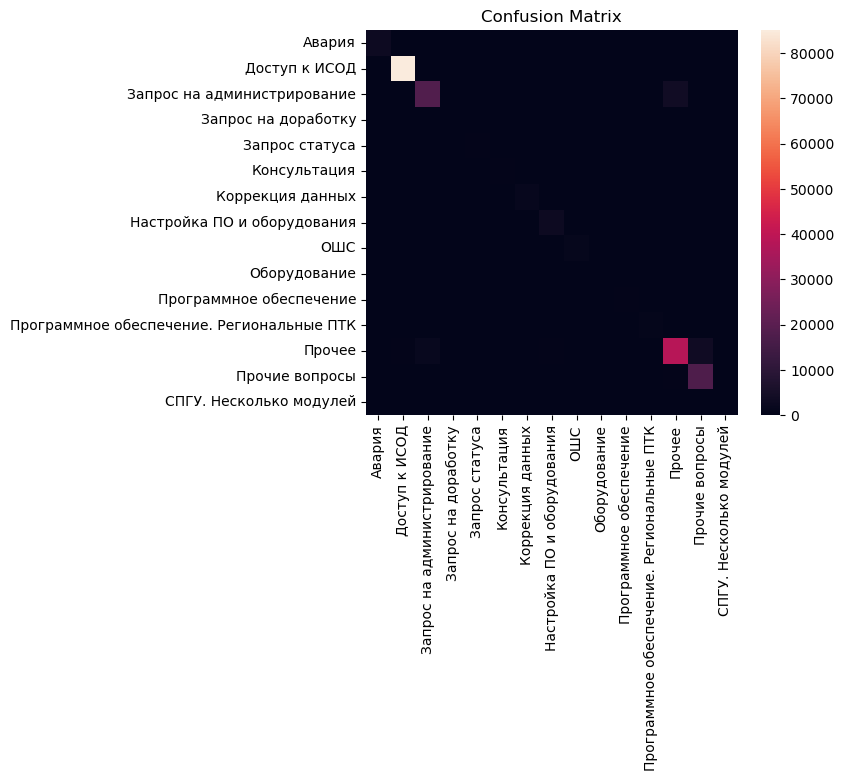

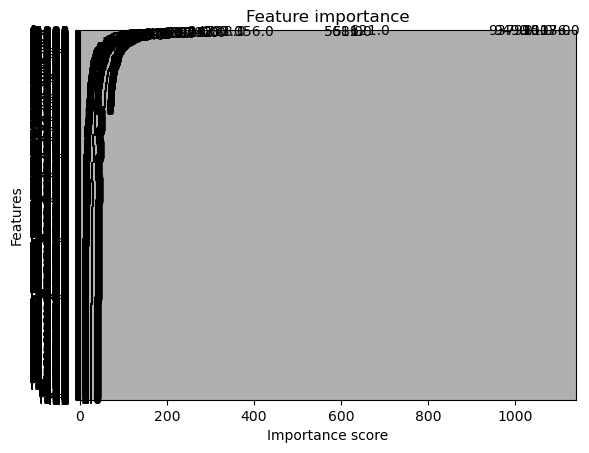

In [ ]:
# 1. Сделать анализ ошибок, посмотреть confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

cm = confusion_matrix(y_test, y_pred, labels=np.arange(le.classes_.shape[0]))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=False, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()

# 2. Подобрать гиперпараметры через RandomizedSearchCV / GridSearchCV для XGBoost

# 3. Попробовать CatBoost и LightGBM для сравнения

# 4. Подготовить данные для K-Fold cross-validation и проверить стабильность

# 5. Посмотреть feature importance
import xgboost as xgb
xgb.plot_importance(model)
plt.show()
